# Instrument response modelling

Demonstration of how to generate and use an instrument response to compare a model with data. Based on some of the ideas in [this](https://grburgess.github.io/fits_files/) example.

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import h5py

from instrument_response.toy_simulation import ToySimulation
from instrument_response.detector import Response

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulation of the detection process

In order to characterise the response of a detector, we need to build a simulation for the detection process. Consider a simple calorimeter, such a simulation would have to include:
* Generation of incident photons/particles
* Effective area of the dectector, or interaction probability of the incoming photons/particles
* Production of secondary particles/photons and their interactions in the detector medium
* Dectection of some observable output of these interactions (e.g. photons in PMTs)

In the real world, these simulations are complex and usually handled by tools like Geant4. For fun, we can look at how it works for a toy model which includes the above simulation steps. The ideas can easily be generalised to a more complex detector and its simulation.

In [2]:
# Run a simulation
# Want to see what goes on at high E without running forever
power_law_index = 1.0 

# Energy range of interest
min_energy = 1 # TeV
max_energy = 100 # TeV

simulation = ToySimulation(power_law_index, min_energy, max_energy)

In [3]:
# Run for large number of particles to generate response
response_file = 'output/response_sim.h5'

# Uncomment this to run again, but can just read from file
#simulation.run(int(1e7))
#simulation.save(response_file)

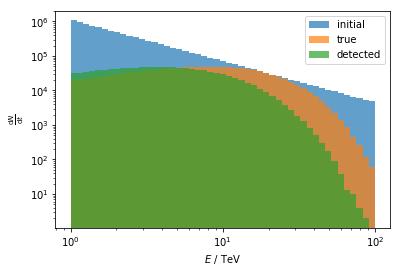

In [4]:
# Read in output to have a look
with h5py.File(response_file, 'r') as f:
    true_energy = f['true_energy'].value
    N_secondaries = f['number_of_secondaries'].value
    N_det_secondaries = f['number_of_detected_secondaries'].value
    detected_energy = f['detected_energy'].value
    initial_energy = f['initial_energy'].value
    
# Plot
bins = np.logspace(np.log(min_energy), np.log(max_energy), base=np.e)

fig, ax = plt.subplots();
ax.hist(initial_energy, bins=bins, alpha=0.7, label='initial')
ax.hist(true_energy, bins=bins, alpha=0.7, label='true');
ax.hist(detected_energy, bins=bins, alpha=0.7, label='detected');
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t}$')
ax.legend();

We can see how the injected energy spectrum changes through different stages of the simulation. The *initial* spectrum is that incident upon the detector, the *true* spectrum is that taking into account the effective area (or interaction probability) and the *detected* is that registered in the detector. In order to compare a model to data, we need to quantify the changes in each of these steps.

## Generating the response matrix

Now that we have a suitable simulation, we can extract the output to build the response matrix. This matrix basically gives us the expected event rate in a 2D bin (initial energy, detected energy), for a given incoming flux.

We start by quantifying the effective area using the initial and true energies. This is just the area of each energy bin.

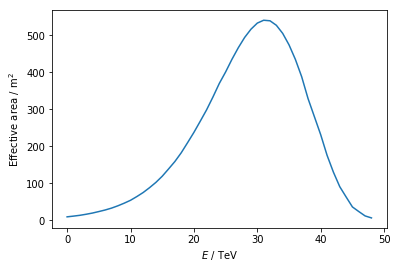

In [5]:
dN_dt_init, _ = np.histogram(initial_energy, bins=bins)
dN_dt_true, _ = np.histogram(true_energy, bins=bins)
bin_centres = bins[:-1] + (bins[1:] - bins[:-1])/2
dA = simulation.effective_area.evaluate(bin_centres)
dN_dtdA_init = dN_dt_init / dA

fig, ax = plt.subplots()
ax.plot(dN_dt_true / dN_dt_init * simulation.effective_area.maximum)
ax.set_xlabel('$E$ / TeV')
ax.set_ylabel('Effective area / $\mathrm{m}^2$');

Now, we want to quantify the energy dispersion. To get this from the simulation, we make a 2D histogram of the true energies and detected energies, then for each bin we divide by the event rate in the true spectrum and multiply by the effective area. This is done in the `Response` class. Here we work with a joint response matrix for both the effective area and the energy dispersion, thus it has units of $\rm{m}^2$.

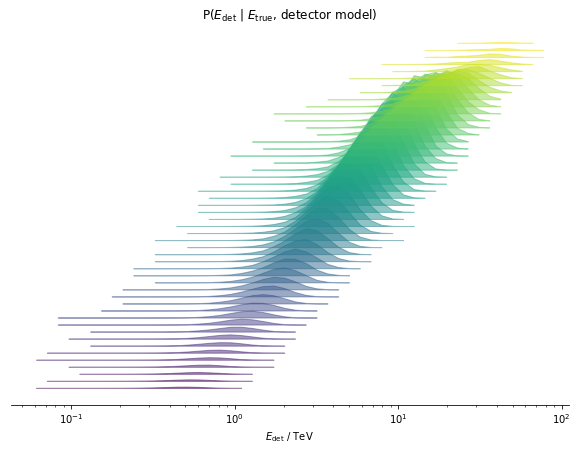

In [6]:
response = Response(initial_energy, true_energy, detected_energy,
                    simulation.effective_area.maximum,
                    nbins_true_energy=50, nbins_detected_energy=50)

response.show()

The above plot shows the response matrix separated out into separate true/initial energy bins. What we have is essentially proportional to a probability distribution, the probability to detect counts with some energy in the detector, given that counts of some true energy are incident upon it. 

We cannot *invert* the matrix to get the true energies for a set of detected energies, because we only know what these could be in a probabilistic sense.

We can also show the matrix directly:



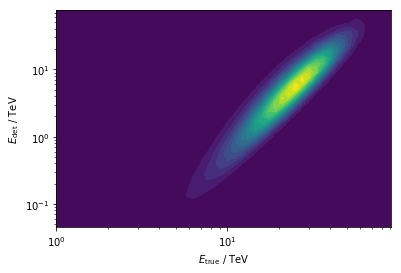

In [7]:
fig, ax = plt.subplots()
ax.contourf(response.true_energy_bins[:-1], response.detected_energy_bins[:-1], 
            response.matrix, 20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{true}$ / TeV')
ax.set_ylabel('$E_\mathrm{det}$ / TeV');

In this simple example, the response matrix is *model independent*, as we divide through by the number of counts in the injected spectrum for each bin. In realistic cases, this can be more difficult to take into account.

## Comparing a model with data

Now that we have quantified the instrument response, we can look at how to use this to compare a model with data. First, let's simulate some example data using the same detector model as was used to generate the response.

In [8]:
true_power_law_index = 2.0
N = int(5e2)
data_file = 'output/data.h5'

simulation = ToySimulation(true_power_law_index, min_energy, max_energy)
simulation.run(N)
simulation.save(data_file)

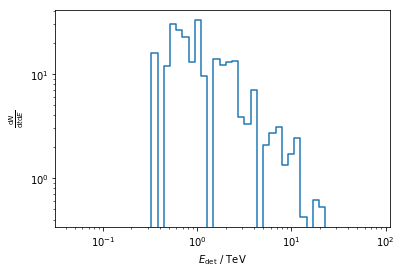

In [9]:
# Have a look at our "data"
with h5py.File('output/data.h5', 'r') as f:
    detected_energy = f['detected_energy'].value

channels = response.detected_energy_bins
dE = np.diff(channels)

# convert detected energies to rate in channels
dN_dt, _ = np.histogram(detected_energy, bins=channels)
dN_dtdE = dN_dt / dE

fig, ax = plt.subplots()
ax.step(channels[:-1], dN_dtdE, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$');

### Forward folding

Now let's consider a model for the energy spectrum, say $\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E} \propto E^{-\alpha}$. We want to use our observed data to infer $\alpha$. To do this, we select some value of $\alpha$, then fold our model through the instrument response to compare with the data. This *forward folding* is a convolution, or matrix multiplication of the model with the response.

In our case, we know the true $\alpha$ from the above simulation, so we can just forward fold to demonstrate that we are able to match the data well. In reality, we would try many different values of $\alpha$, and compare each to the data with a statistical method to asses which on provides the "best fit".

In [10]:
# Model
from instrument_response.power_law import BoundedPowerLaw

alpha = 2.0
power_law = BoundedPowerLaw(alpha, min_energy, max_energy)

In [11]:
# Normalise our model to match the simulated flux
def differential_flux(e):
    return simulation.total_dN_dtdA * power_law.pdf(e)

# integral of the differential flux (simpson's rule)
def integral(e1, e2):
    return ((e2 - e1) / 6.0) * (differential_flux(e1) 
                              + 4 * differential_flux((e1 + e2) / 2.0) 
                              + differential_flux(e2))

# For our model, calculate the rate in each true energy bin
dN_dtdA = integral(response.true_energy_bins[:-1], response.true_energy_bins[1:])

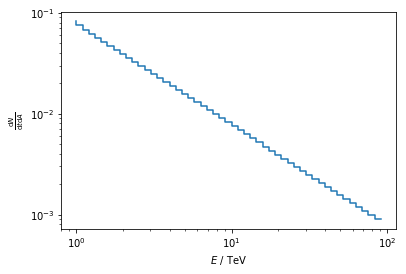

In [12]:
fig, ax = plt.subplots()

ax.step(response.true_energy_bins[:-1], dN_dtdA, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d}t \mathrm{d}A}$');

As expected, our model is a power law with index $\alpha=2$.

In [13]:
# Get folded counts in the detector by taking the dot product with the response
dN_dt_model = np.dot(dN_dtdA, response.matrix) # dN/dtdA * dA -> dN/dt 
dN_dtdE_model = dN_dt_model / dE

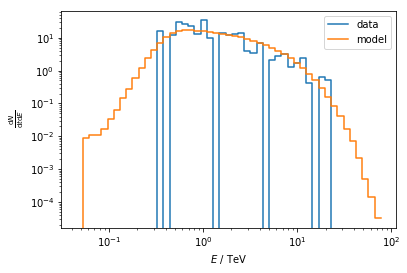

In [14]:
# Compare folded model and data
fig, ax = plt.subplots()

dE = np.diff(response.detected_energy_bins)
ax.step(channels[:-1], dN_dtdE, where='pre', label='data')
ax.step(channels[:-1], dN_dtdE_model, where='pre', label='model')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$')
ax.legend();

Again, as expected, we have a good match between the model and data in the energy range of our detector. If we would change alpha to some other value, we would see discrepancies in the model and data (just change $\alpha$ above and re-run). See the other notebook in this repository, `fit_demo.ipynb` for how to fit for $\alpha$ if it is unknown.